In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os

import sys
sys.path = ['/Users/rejsmont/PycharmProjects/rdn-wdp-python/analysis'] + sys.path

from CellModels.Clustering.IO import ClusteringReader

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


scanpy==1.7.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.6.2 pandas==1.2.4 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0 leidenalg==0.8.3


In [3]:
basedir = "/Users/rejsmont/Google Drive/My Drive/Projects/RDN-WDP/"
datadir = os.path.join(basedir, 'sharing')
counts = pd.read_csv(os.path.join(datadir, 'export', 'aerts_counts.csv'), index_col=0)
counts.index = counts.index.astype(str)
counts

,128up,14-3-3epsilon,14-3-3zeta,140up,18SrRNA-Psi:CR41602,18w,26-29-p,28SrRNA-Psi:CR40596,28SrRNA-Psi:CR40741,28SrRNA-Psi:CR41609,...,z,zetaCOP,zf30C,zfh1,zfh2,zip,zld,zormin,zuc,zyd
0,0,12,9,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
1,0,7,6,0,0,0,0,1,0,0,...,0,1,0,1,0,3,0,0,0,0
2,0,37,20,1,0,0,1,1,0,0,...,1,0,0,0,0,5,1,0,0,0
3,0,25,19,0,0,0,1,1,0,0,...,0,1,0,0,1,7,0,0,0,0
4,2,8,6,0,0,3,0,0,0,0,...,0,1,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2377,1,29,23,0,0,1,2,0,0,0,...,1,4,0,0,1,3,5,0,0,0
2378,1,37,19,1,0,0,16,0,0,0,...,0,1,1,6,0,18,0,0,0,0
2379,0,34,19,0,0,1,4,0,0,0,...,1,3,0,1,3,0,0,0,0,6
2380,4,88,77,1,0,3,17,1,0,0,...,0,9,3,0,0,85,8,2,0,0


In [4]:
genes = counts.columns.to_frame().rename(columns={0: 'gene_ids'})
genes

,gene_ids
128up,128up
14-3-3epsilon,14-3-3epsilon
14-3-3zeta,14-3-3zeta
140up,140up
18SrRNA-Psi:CR41602,18SrRNA-Psi:CR41602
...,...
zip,zip
zld,zld
zormin,zormin
zuc,zuc


In [5]:
cells = pd.read_csv(os.path.join(datadir, 'export', 'aerts_cells.csv'), index_col=0) \
          .iloc[:, 0].str.split("-", n = 1, expand = True) \
          .rename(columns={0: 'barcode', 1: 'replica'})
cells.index = cells.index.astype(str)
cells

,barcode,replica
0,AACCGCGGTTGAGTTC,1
1,AACGTTGCAATCACAC,1
2,AACTCCCGTTCTGGTA,1
3,AACTCCCTCCCAAGTA,1
4,AACTCCCTCTGCGTAA,1
...,...,...
2377,TTTGGTTCAAGAAAGG,2
2378,TTTGGTTTCTATCCTA,2
2379,TTTGTCACAGCGATCC,2
2380,TTTGTCAGTACCGGCT,2


In [6]:
clusters = pd.read_csv(os.path.join(datadir, 'export', 'clusters.csv'), index_col=0)
clusters

,0
1,R8 ato(+)
2,MF ato(+++)
3,peripodial
4,posterior
5,anterior
6,MF ato(+)
7,non-R8


In [7]:
targets = pd.read_excel(os.path.join(basedir, 'Work Plan GO.xlsx'), header=[0,1])
targets = targets.loc[:205, ['Gene', 'Target', 'Fosmid']] \
                 .rename(columns={'Unnamed: 0_level_1': 'gene', 'Unnamed: 5_level_1': 'fosmid'}) \
                 .droplevel(0, axis='columns')

for column in ['ey', 'ato', 'sens', 'Su(H)', 'fosmid']:
    targets[column] = targets[column] == 'yes'

ato_targets = targets.loc[targets['ato'], 'gene'].sort_values().to_list()
sens_targets = targets.loc[targets['sens'], 'gene'].sort_values().to_list()
ey_targets = targets.loc[targets['ey'], 'gene'].sort_values().to_list()

In [8]:
imaging = ClusteringReader.read(basedir + '/processing/clustering/bigc100k6n20r1000_metadata.yml')
imaged_genes = imaging.cells.index.unique('Gene').to_list()

In [9]:
adata = sc.AnnData(X = counts.values, obs = cells, var=genes)
adata.layers['raw'] = adata.X
imaging = pd.read_csv(os.path.join(datadir, 'export', 'aerts_clusters.csv'), index_col=0)
adata.obs['imaging'] = imaging['Cluster'].astype('str').astype('category').values
adata

AnnData object with n_obs × n_vars = 2382 × 11010
    obs: 'barcode', 'replica', 'imaging'
    var: 'gene_ids'
    layers: 'raw'

In [10]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=5)
adata

filtered out 10 cells that have less than 1000 genes expressed
filtered out 681 genes that are detected in less than 5 cells


AnnData object with n_obs × n_vars = 2372 × 10329
    obs: 'barcode', 'replica', 'imaging', 'n_genes'
    var: 'gene_ids', 'n_cells'
    layers: 'raw'

normalizing counts per cell
    finished (0:00:00)


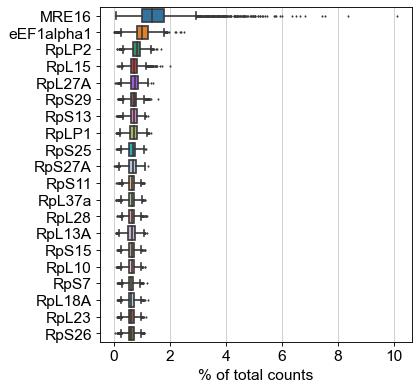

In [11]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
adata.var['mt'] = adata.var_names.str.startswith('mt:')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'barcode' as categorical
... storing 'replica' as categorical


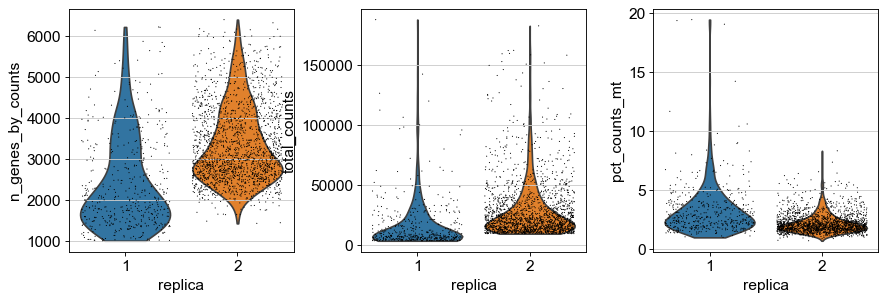

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 'replica', jitter=0.4, multi_panel=True)

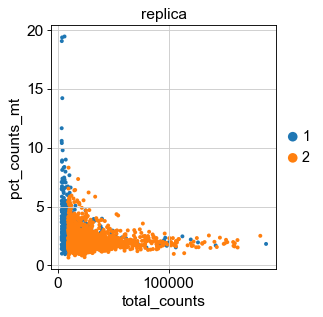

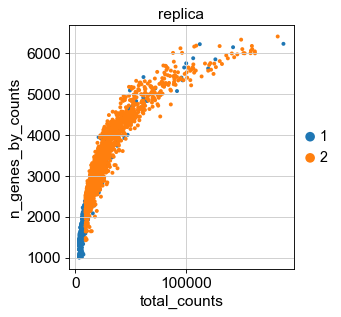

In [14]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='replica')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='replica')

In [15]:
adata = adata[adata.obs.n_genes_by_counts < 5500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True)
sc.pp.log1p(adata)

/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['CR43283', 'Hug', 'MRE16', 'noe', 'pncr002:3R', 'pros']
    finished (0:00:00)


In [16]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='raw', n_top_genes=3000)
adata.var['highly_variable'] = adata.var['highly_variable'] & adata.var.index.isin(ato_targets)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [17]:
adata_raw = adata
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:29)


In [18]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


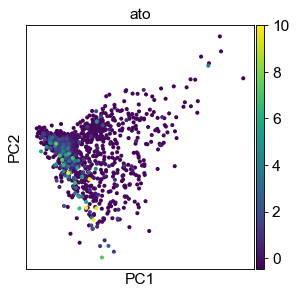

In [19]:
sc.pl.pca(adata, color='ato')

In [20]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata, n_components=3)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


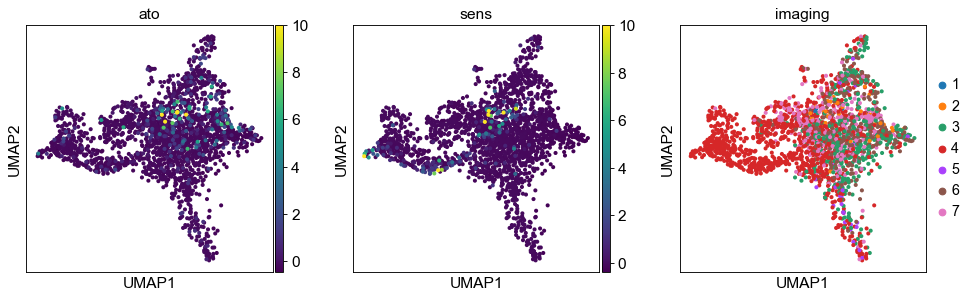

In [21]:
sc.pl.umap(adata, color=['ato', 'sens', 'imaging'])

In [22]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='raw', n_top_genes=3000)
adata.var['highly_variable'] = adata.var['highly_variable'] & \
    (adata.var.index.isin(ato_targets) | adata.var.index.isin(sens_targets))

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [23]:
adata_raw = adata
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:25)


In [24]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


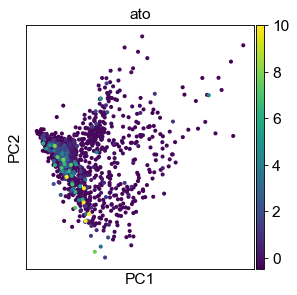

In [25]:
sc.pl.pca(adata, color='ato')

In [26]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata, n_components=3)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


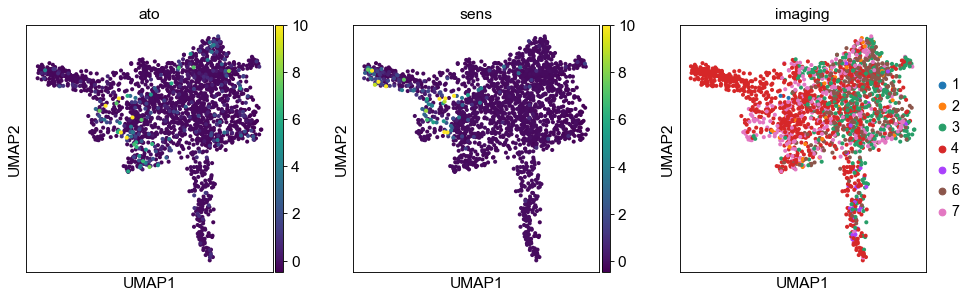

In [27]:
sc.pl.umap(adata, color=['ato', 'sens', 'imaging'])

In [28]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='raw', n_top_genes=3000)
adata.var['highly_variable'] = adata.var['highly_variable'] & adata.var.index.isin(imaged_genes)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/usr/local/anaconda3/envs/rdn-wdp-new/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [29]:
adata_raw = adata
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:25)


In [30]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)


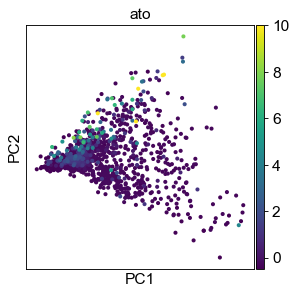

In [31]:
sc.pl.pca(adata, color='ato')

In [32]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata, n_components=3)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


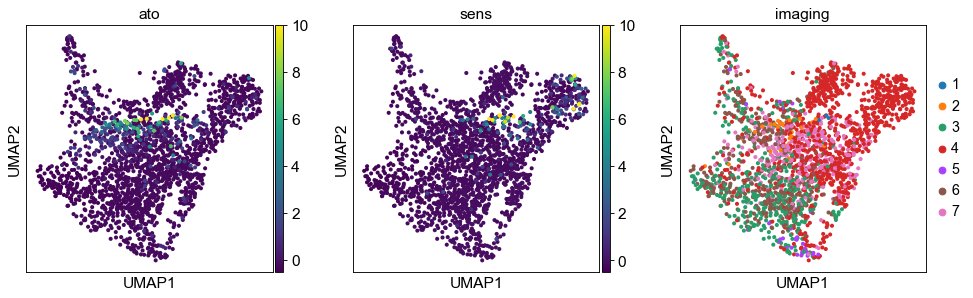

In [33]:
sc.pl.umap(adata, color=['ato', 'sens', 'imaging'])